## 6.2 랭그래프 활용

### 6.2.1 루프 구현하기

In [2]:
%%capture --no-stderr
%pip install -U langgraph
%pip install -U langchain-openai
%pip install -U python-dotenv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수 로드
load_dotenv("/content/drive/MyDrive/Colab Notebooks/.env")

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 실습에서 사용할 그래프의 상태값 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 실습에서 사용할 그래프 정의
graph_builder = StateGraph(State)

In [6]:
from langchain_openai import ChatOpenAI

# 오픈AI 클라이언트 정의
llm = ChatOpenAI(model="gpt-4o-mini")

# 오픈AI를 호출하여 응답을 받아 온 뒤, 상태값에 저장하여 반환하는 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 챗봇 노드 정의
graph_builder.add_node("chatbot", chatbot)

In [7]:
from langgraph.graph import StateGraph, START, END
# 진입지점
graph_builder.add_edge(START, "chatbot")
# 종료지점
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

In [11]:
while True:
    # 사용자의 질의 입력받음 
    user_input = input("User: ")
    print("User:", user_input)
    
    # 사용자가 quit 혹은 exit 혹은 q를 입력했다면 루프 종료
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
        
    # 사용자의 입력을 그래프에 입력하여 정의된 흐름 실행
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


User: 너는 누구야?
Assistant: 저는 OpenAI에서 개발한 AI 언어 모델입니다. 질문에 답변하거나 정보를 제공하는 데 도움을 줄 수 있습니다. 무엇을 도와드릴까요?
User: 반가워!
Assistant: 반가워요! 어떻게 도와드릴까요?
User: exit
Goodbye!


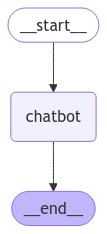

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### 6.2.2 조건문 구현하기

In [13]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

In [ ]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("/content/drive/MyDrive/Colab Notebooks/.env")

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Tavily검색 엔진을 도구로 정의
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("내일 대한민국 서울의 날씨는?")

[{'url': 'https://weather.com/ko-KR/weather/tenday/l/82e46175f97c224acf6b95afc4934fbae0e4ba123adcee8a52b7be97c303467b',
  'content': 'recents\n전문 예보\n10일 날씨-서울특별시\n오늘 밤\n화 13 | 밤\n대체로 흐림. 풍향 남이며 변화 심함.\n수 14\n수 14 | 일\n부분적으로 흐림. 풍향 북북동이며 변화 심함.\n토 24\n토 24 | 일\n부분적으로 흐림. 풍향 남남동이며 변화 심함.\n토 17\n토 17 | 일\n부분적으로 흐림. 풍향 북북서이며 변화 심함.\n토 24 | 밤\n부분적으로 흐림.'},
 {'url': 'https://www.accuweather.com/ko/kr/seoul/226081/hourly-weather-forecast/226081',
  'content': 'Hourly weather forecast in 서울특별시, 서울시, 대한민국. Check current conditions in 서울특별시, 서울시, 대한민국 with radar, hourly, and more.'}]

In [17]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


# 그래프 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 그래프 정의
graph_builder = StateGraph(State)

# 오픈AI 클라이언트 정의
llm = ChatOpenAI(model="gpt-4o-mini")
# 오픈AI 클라이언트에 Tavily 검색 엔진 도구를 할당 
llm_with_tools = llm.bind_tools(tools)

# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 그래프에 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [18]:
import json

from langchain_core.messages import ToolMessage


# 도구 노드로 사용될 클래스
class BasicToolNode:

    # 도구 노드에서 사용될 초기 파라미터 정의
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    # 도구 노드가 호출되었을때의 행동 정의
    def __call__(self, inputs: dict):
        # 입력된 상태의 가장 마지막 메세지 획득 
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        # 메세지의 tool_calls 에 도구호출을 위한 값들이 존재한다면 이를 활용해 도구 호출
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 도구 호출의 결과물을 ToolMessage로 정의하여 출력값에 저장
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # 출력값을 상태값 형식에 맞춰 반환 
        return {"messages": outputs}


# 도구 노드 정의
tool_node = BasicToolNode(tools=[tool])
# 도구 노드 그래프에 추가
graph_builder.add_node("tools", tool_node)

In [19]:
from typing import Literal


# 도구노드 호출 여부를 결정하는 함수 정의
def route_tools(
        state: State,
) -> Literal["tools", "__end__"]:
    # 상태값의 가장 최근 메세지를 정의 
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # 가장 최근 메세지가 tool_calls 속성을 포함하고 있다면 tools 노드를 아니라면 종료지점을 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# 챗봇 노드에 조건부 엣지를 정의
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)

In [21]:
# 도구 노드와 챗봇 노드 연결
graph_builder.add_edge("tools", "chatbot")
# 진입지점으로 챗봇 노드 지정
graph_builder.add_edge(START, "chatbot")

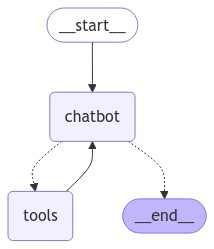

In [22]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### 6.2.3 스트리밍

In [23]:
from langchain_core.messages import BaseMessage

while True:
    # 사용자의 질문을 입력받습니다 
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # 업데이트된 내용을 확인할 수 있는 그래프 스트리밍을 정의합니다. 
    events = graph.stream(input={"messages": [("user", user_input)]}, stream_mode="updates")
    
    # 그래프 이벤트 내의 메세지를 출력합니다.
    for event in events:
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)


User: 24년 9월 9일 서울 날씨는 어때?
Assistant: 
Assistant: [{"url": "https://hikersbay.com/climate/september/southkorea/seoul?lang=ko", "content": "9월 2024 에 서울특별시 의 날씨 조건에 대한 간략한 설명 ... 가장 긴 날은 년 9월 1일 월요일 이며, 12 시간 60 분 의 일광을 제공합니다, 일출은 오전 6:03 에, 일몰은 오후 7:03 에 있습니다. 여행자에게 햇빛 시간은 중요합니다. 이번 달은 평균적으로 12 시간의 일광이 ..."}, {"url": "https://dataful.kr/460", "content": "9월 서울 날씨 예보 3주 4주 9월 16일~29일 주별 기온 비 더위 전망 및 9월 서울 평균 기온 2024년 9월 3주 4주 서울 지역의 날씨 예보를 알려드립니다. 1. 2024년 9월 3주 4주 9월 16일~29일 서울 지역 기온 예보 2024년 9월 3주 4주 9월 16일~29일 서울 지역 기온 예보 예측 결과 9월 3주 9월 16일~22일 기간 서울의 기온은 평년 기온보다 높을 것으로 예보되었습니다. 예측 결과 9월 4주 9월 23일~29일 기간 서울의 기온은 평년 기온보다 높을 것으로 예보되었습니다. 예측 결과 9월 3주 9월 16일~22일 기간 서울의 강수량은 평년 강수량보다 많을 것으로 예보되었습니다. 예측 결과 9월 4주 9월 23일~29일 기간 서울의 강수량은 평년 강수량보다 많을 것으로 예보되었습니다. 마지막으로 정리하자면 2024년 9월 3주 4주 기간 동안 서울은 평소보다 기온이 높을 것으로 보입니다."}]
Assistant: 2024년 9월 9일 서울의 날씨에 대한 정보는 다음과 같습니다:

- 9월은 대체로 기온이 평년보다 높을 것으로 예측되고 있으며, 강수량도 평년보다 많을 것으로 보입니다.
- 평균적으로 9월의 서울은 일조 시간이 약 12시간으로, 일출은 오전 6시 3분, 일몰은 오후 7시 3분입니다.


### 6.2.4 상태 저장하기

In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [27]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# 미리 빌드된 도구노드
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 미리 빌드된 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 체크포인터를 지정하여 그래프를 컴파일
graph = graph_builder.compile(checkpointer=memory)

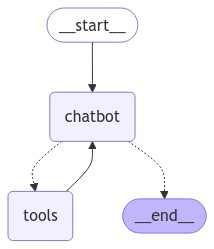

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
config = {"configurable": {"thread_id": "1"}}

In [30]:
user_input = "안녕! 내 이름은 오해원이야."

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕! 내 이름은 오해원이야.
================================== Ai Message ==================================

안녕하세요, 오해원님! 반갑습니다. 어떻게 도와드릴까요?


In [31]:
user_input = "내 이름을 기억하니?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름을 기억하니?
================================== Ai Message ==================================

네, 오해원님! 당신의 이름을 기억하고 있습니다. 다른 질문이나 도움이 필요하신 부분이 있나요?


In [32]:
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름을 기억하니?
================================== Ai Message ==================================

죄송하지만, 이전 대화의 내용을 기억할 수 없어서 당신의 이름을 알 수 없습니다. 당신의 이름을 알려주시면 기억하겠습니다!


In [33]:
snapshot = graph.get_state(config)
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='안녕! 내 이름은 오해원이야.', additional_kwargs={}, response_metadata={}, id='0cc11544-9e2f-4ddb-997d-25a5919e4604'), AIMessage(content='안녕하세요, 오해원님! 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 90, 'total_tokens': 110, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'stop', 'logprobs': None}, id='run-03af035b-10b1-43cd-9623-c9bda70349c8-0', usage_metadata={'input_tokens': 90, 'output_tokens': 20, 'total_tokens': 110}), HumanMessage(content='내 이름을 기억하니?', additional_kwargs={}, response_metadata={}, id='ad673abb-54f7-4aea-a6a4-546947025f7c'), AIMessage(content='네, 오해원님! 당신의 이름을 기억하고 있습니다. 다른 질문이나 도움이 필요하신 부분이 있나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 124, 'total_tokens': 152

### 6.2.5 루프 개입하기

In [34]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
)

In [35]:
user_input = "지금 서울 날씨 어때?"
config = {"configurable": {"thread_id": "2"}}
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

지금 서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yuDFf1bqfno66lEjSTR3MaDh)
 Call ID: call_yuDFf1bqfno66lEjSTR3MaDh
  Args:
    query: 서울 날씨


In [36]:
snapshot = graph.get_state(config)
print(snapshot.next)

('tools',)


In [37]:
from langchain_core.messages import AIMessage

# 최근 메세지
existing_message = snapshot.values["messages"][-1]
# 최근 메세지의 id
existing_message_id = existing_message.tool_calls[0]["id"]

# 강제할 응답 정의
answer = (
    "서울의 날씨는 매우 맑아요."
)

# 강제할 응답을 포함한 메세지 상태 정의
new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message_id),
    AIMessage(content=answer),
]
# 그래프 상태를 새로 작성한 메세지 상태로 변경
graph.update_state(
    config,
    {"messages": new_messages},
)


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef79b76-b3e2-632a-8005-79e5c72e77ab'}}

In [38]:
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[ToolMessage(content='서울의 날씨는 매우 맑아요.', id='0b904976-06cb-47b0-b01e-b481b81182b2', tool_call_id='call_yuDFf1bqfno66lEjSTR3MaDh'), AIMessage(content='서울의 날씨는 매우 맑아요.', additional_kwargs={}, response_metadata={}, id='dd9ee60e-4631-45fe-b5d6-a12462bace82')]


In [39]:
existing_message = snapshot.values["messages"][-3]
print(existing_message)

content='죄송하지만, 이전 대화의 내용을 기억할 수 없어서 당신의 이름을 알 수 없습니다. 당신의 이름을 알려주시면 기억하겠습니다!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 86, 'total_tokens': 120, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e9627b5346', 'finish_reason': 'stop', 'logprobs': None} id='run-f10911f7-501f-4aa5-b477-306753752a9b-0' usage_metadata={'input_tokens': 86, 'output_tokens': 34, 'total_tokens': 120}


In [40]:
from langchain_core.messages import AIMessage

user_input = "지금 서울 날씨 어때?"
config = {"configurable": {"thread_id": "3"}}
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

지금 서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_NQZyVhdGDnr34GDgCb4bK8Qo)
 Call ID: call_NQZyVhdGDnr34GDgCb4bK8Qo
  Args:
    query: 서울 날씨


{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef79b77-d361-6c36-8002-b1d6d86a16f1'}}

In [ ]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "지금 경기도 날씨 어때?"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    id=existing_message.id,
)

graph.update_state(config, {"messages": [new_message]})

In [41]:
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[HumanMessage(content='지금 서울 날씨 어때?', additional_kwargs={}, response_metadata={}, id='abd0c63d-5e3e-453b-a67e-31f8ab9f6163'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-858aa847-9b80-479d-a194-9e07e8043f4e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '지금 경기도 날씨 어때?'}, 'id': 'call_NQZyVhdGDnr34GDgCb4bK8Qo', 'type': 'tool_call'}])]
